<a href="https://colab.research.google.com/github/cafalchio/EXvivo/blob/main/EEG_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading data format Intan .dat

In [1]:
!pip install MNE -q

     |████████████████████████████████| 7.4 MB 4.8 MB/s 


# LFP load and plot

In [129]:
import glob, os
import mmap
from tqdm.notebook import tqdm
import sys
import pandas as pd
import numpy as np
import mne

import matplotlib.pyplot as plt
# import zipfile
import struct
from resource import getrusage, RUSAGE_SELF
import gc
gc.enable()
# load data
sys.path.append("/content/drive/MyDrive/aHuman_data_Mark/load_intan_rhd_format/")
from load_intan_rhd_format import read_data, read_header
from scipy import signal

## **Read metadata from recording**

Need the channel distribuition of the probe!!


Todo:
<ul>
    <li>Open channels by name or group</li>
    <li>Create MNE objects for EEG</li>
    <li>Bandpass </li

</ul>

Auxiliary functions

From Matlab file analysis

    pxx(1,:) = bandpower(px, f, [1,4], 'psd'); % delta
    pxx(2,:) = bandpower(px, f, [1,4], 'psd'); % duplication of delta - for     creating surf plots
    pxx(3,:) = bandpower(px, f, [4,8], 'psd'); % theta
    pxx(4,:) = bandpower(px, f, [8,13], 'psd'); % alpha
    pxx(5,:) = bandpower(px, f, [13, 30], 'psd'); % beta
    pxx(6,:) = bandpower(px, f, [20, 80], 'psd'); % low gamma

In [130]:
def butter_filter(data, sample_frequency = 25000., freqs=300, filttype = 'highpass', plot_response = False):
    """
    Filter using bidirectional zero-phase shift Butterworth filter.
    Parameters
    ----------
    data : ndarray
        Data or signal to filter
    sample_frequency : Sampling frequency

    wp :
        Arguments with filter paramters
    Returns
    -------
    ndarray
        Filtered signal
    """
    gstop = 20  # minimum dB attenuation at stopabnd
    gpass = 3  # maximum dB loss during ripple
    nyquist = sample_frequency / 2
    
    if filttype == 'lowpass':
        wp = freqs / nyquist
        ws = min([wp + 0.1, 1])
    elif filttype == 'highpass':
        wp = freqs / nyquist
        ws = max([wp - 0.1, 0.01 / nyquist])
    elif filttype == 'bandpass':
        wp = [freq / nyquist for freq in freqs] 
        ws = np.zeros_like(wp)
        ws[0] = max([wp[0] - 0.1, 0.01 / nyquist])
        ws[1] = min([wp[1] + 0.1, 1])
    min_order, min_wp = signal.buttord(wp, ws, gpass, gstop)
    b, a = signal.butter(min_order, min_wp, btype=filttype, output='ba')
    freq, h = signal.freqz(b, a, fs=sample_frequency)
    if plot_response:
        # Plot
        fig, ax = plt.subplots(2, 1, figsize=(8, 6))
        ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
        ax[0].set_title("Frequency Response")
        ax[0].set_ylabel("Amplitude (dB)", color='blue')
        # ax[0].set_xlim([freqs[0], freq[1]*.3])
        ax[0].set_ylim([-25, 10])
        ax[0].grid()
        ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
        ax[1].set_ylabel("Angle (degrees)", color='green')
        ax[1].set_xlabel("Frequency (Hz)")
        # ax[1].set_xlim([0, freqs*10])
        ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
        ax[1].set_ylim([-90, 90])
        ax[1].grid()
        plt.show()
        print(f"\nwp: {wp} \nws: {ws}\norder: {min_order}")

    return signal.filtfilt(b, a, data)

In [131]:
def read_treatment_times(df, slice):
    '''read_times for normal, modified and prepanel

    Input: 
        (df):dataframe with times and treatment
        (str):string of slice name
    Returns:
        normal, modified and perapanel times in minutes
    '''
    times = df.loc[df.slice == 'slice1_151008_165239']
    t_dict = times.to_dict('records')[0]
    animal = t_dict['animal']
    chunks = t_dict['chunks']
    modified = t_dict['modified'].split() 
    normal = t_dict['normal'].split()
    perapanel = t_dict['perapanel'].split()
    print('normal, modified, perapanel, chunks')
    return normal, modified, perapanel, chunks

In [132]:
class LFP:
    def __init__(self, path_to_data):
        self.path_to_data = path_to_data
        self.eeg_files = self.find_eeg_files()
        print(f'Found in folder {len(self.eeg_files)} LFP channels')
    
    def find_eeg_files(self, group='A'):
        return sorted(glob.glob(self.path_to_data+'/amp-'+ group +'*.dat'))

    def read_channel(self, channel_idx):
        '''Function that reads a single LFP channel'''
        channel_file = self.eeg_files[channel_idx]        
        data_ch = np.fromfile(channel_file, dtype=np.int16)
        return data_ch

    def plot_raw_sample(self):
        ax = plt.figure(figsize=(20,6))
        ax = plt.plot(1/self.timestamp[2500:5000], self.data[2500:5000])
        ax = plt.ylabel('Voltage uV')
        ax = plt.xlabel('Time (s)')
        plt.show()
        plt.close()

    @staticmethod
    def get_memory_use():
        '''Auxiliary function to check memory use
        '''
        mem = getrusage(RUSAGE_SELF).ru_maxrss/1024000
        print(f'Memory use: {mem:.1f}Gb')
    
    def load_eeg_channels(self, ch_idxs):
        '''
        Read a list of channels and transform from microvolts to volts
        '''
        res = [self.read_channel(ch_idx)/1000000 for ch_idx in tqdm(ch_idxs)] # from microvolts to volts
        return res
    
    def load_mne_channels(self, ch_idxs):
        ''' Load channels by its name ex([0,1]) and 
        transform the EEG to MNE objects, can open 20 
        EEGs per time. It is recommended to open 
        a chunk of 8 files at time
        '''
        print('Reading channels ..')
        data = self.load_eeg_channels(ch_idxs)
        ch_types = len(ch_idxs) * ['eeg']
        names = [f'ch_{idx}' for idx in ch_idxs]
        info = mne.create_info(ch_names=names, sfreq=2500, ch_types=ch_types)
        print('Creating mne EEG type')
        data =  mne.io.RawArray(np.array(data), info, verbose='ERROR')
        print('Applying notch filter')
        data = data.notch_filter(np.arange(50, 251, 50)) # Filter 50Hz
        print('Bandpassing 1 - 100 Hz')
        data = data.filter(l_freq=1, h_freq=100)
        self.get_memory_use()
        print('Done!')
        return data

In [133]:
!ls '/content/drive/MyDrive/aHuman_data_Mark/'

 HUMAN_212	     img			 probe_amp_map.txt
'HUMAN 213'	     load_intan_rhd_format	 ReadIntanSpikeFile.zip
 HUMAN_214	     load_intan_rhd_format.zip	 spike2_file
'Human Record.pdf'   metadata_experiments.csv	 treatment_times.csv


In [134]:
df = pd.read_csv('/content/drive/MyDrive/aHuman_data_Mark/treatment_times.csv')
df.head(10)

,slice,animal,normal,modified,perapanel,uM,chunks
0,slice1_151002_185204,212,0,26,89,3,1
1,slice1_151008_165239,213,0 248,18 178,86,1,1
2,slice1_151015_130152,214,0 204,20 174,82,1,1
3,slice2_151015_165854,214,0 204,10 194,88,1,1
4,slice1_151020_133348,215,0 256,69 196,130,1,1
5,slice2_151020_185053,215,0 224,50 186,110,1,1
6,session1_151106_154501,216,0 315,60 255,121 195,1 3,2
7,human_151124_145847,218,0,20,80,1,2
8,human_151124_172920,218,0,10,70,1,2
9,human_151124_200111,218,0,5,55,1,2


In [135]:
treatment_times = read_treatment_times(df, 'slice1_151008_165239')
treatment_times

normal, modified, perapanel, chunks


(['0', '248'], ['18', '178'], ['86'], 1)

In [141]:
# Load the data folder
lfps = LFP(r'/content/drive/MyDrive/aHuman_data_Mark/HUMAN_212/slice1_151002_212538//downsampleLFP')
len(lfps.eeg_files)

Found in folder 64 LFP channels


64

In [142]:
lfps.load_eeg_channels([0])

  0%|          | 0/1 [00:00<?, ?it/s]

[array([2.8e-05, 8.2e-05, 7.0e-05, ..., 5.0e-06, 3.0e-06, 7.0e-06])]

In [143]:
LFPs = lfps.load_mne_channels(range(63))

Reading channels ..


  0%|          | 0/63 [00:00<?, ?it/s]

Creating mne EEG type
Applying notch filter
Bandpassing 1 - 100 Hz
Memory use: 10.6Gb
Done!


In [154]:
print(f'Recorded for {len(LFPs.get_data(0)[0])/2500} s')

Recorded for 1993.1184 s


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


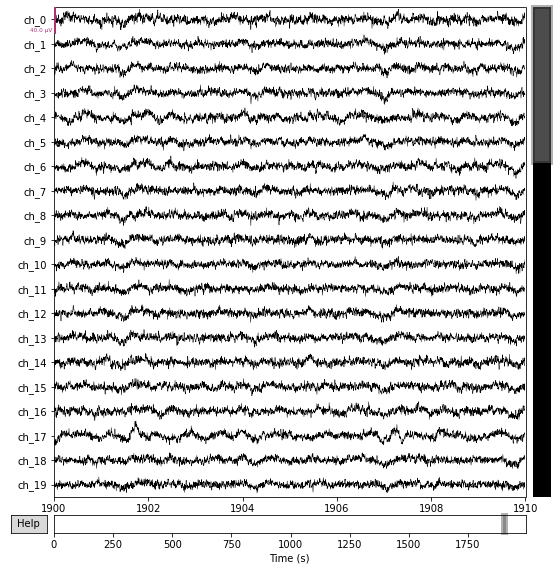

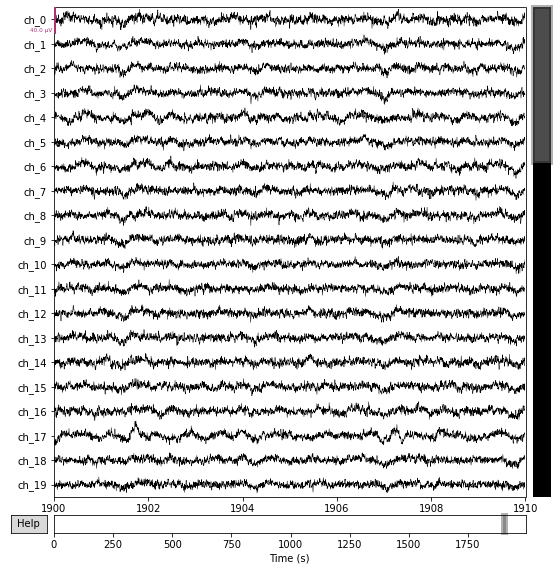

In [156]:
LFPs.plot(start=1900)

## plot LFP

In [160]:
# def plot_raw(wave, fs=1000, size = 1):

#     t_window = size*fs #window in seconds
#     lenght = len(wave)
#     n_fig = int(lenght / t_window) # number of figures of lenght t_window
#     r_window = lenght % t_window # rest of samples window
#     extra = 1 if r_window != 0 else 0
#     n_fig = n_fig + extra
#     x = np.linspace(0, wave.size/fs , wave.size)
#     mean_pos = np.ones(len(wave)) * np.mean(abs(wave))
#     mean_neg = np.ones(len(wave)) * -np.mean(abs(wave))
#     fig, axs = plt.subplots(n_fig+extra, 1, figsize=(24, (n_fig+1) * 3))
    
#     for i in range(n_fig):
#         if i <= n_fig-1:
#             part_wave = wave[i * t_window : i * t_window + t_window]
#             x2 = x[i * t_window : i * t_window + t_window]
#             m_pos = mean_pos[i * t_window : i * t_window + t_window]
#             m_neg = mean_neg[i * t_window : i * t_window + t_window]
#         else:
#             part_wave = wave[i * t_window :]
#             x2 = x[i * t_window :]
#             m_pos = mean_pos[i * t_window :]
#             m_neg = mean_neg[i * t_window :]
#         if i == 0: 
#             axs[i].title.set_text(f'Data plot windows of {size} minutes')
#         axs[i].plot(x2, part_wave, alpha = .8, c='b')
#         # axs[i].plot(x2, m_pos*6,  c='black', alpha = .3)
#         # axs[i].plot(x2, m_neg*6,  c='black', alpha = .3)
#         axs[i].set_ylim(m_neg[0]*10, m_pos[0]*10)
#         # axs[i].get_yaxis().set_ticks([])
#         # axs[i].ticklabel_format(axis='x', style='plain', useOffset= -i * t_window, useMathText=True)
#         axs[i].set_ylabel('V')
#     axs.flat[-1].set_visible(False)
#     fig.tight_layout()
#     # plt.savefig('C-001_1_800Hz_1min_C-001.jpg', dpi=50)
#     plt.show()

# run = 60 #seconds
# for i in range(int((perpanel-modified)/run*fs)):
    
#     print(f'{i*run} seconds')
#     ax = plt.figure(figsize=(28,4))
#     ax = plt.plot(data_eegs[i * run*fs : (i + 1) * run* fs])
#     ax = plt.ylim(-5*1e-5, 5*1e-5)
#     plt.show()
#     plt.close()

## RAT 212:

### Separate the different treatment times
**Times in minutes:**
    
    0 - normal ACSF
    
    26m - modified
    
    89m - 3uM Perapanel




In [ ]:
fs = 2500
modified = 26*60*2500 #modified
perpanel = 89*60*2500 #Perpanel

0 seconds


NameError: ignored

<Figure size 2016x288 with 0 Axes>